# T2* motion correction tutorial

Start by importing the required libraries and defining some settings:

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from MDR_Library.MDR import MDR
from ukat.data import fetch
from ukat.mapping.t2star import T2Star
import ukat.moco.mdr_functions as mdr_functions

# Ensure figures are rendered in the notebook
%matplotlib inline

Tell python where to store the T2* maps NIfTI files we will generate. We will store it in a directory called `t2star_motion_output` in the `tutorials` directory.

In [2]:
# Initialise output path for T2star map
directory = 't2star_motion_output'
os.makedirs(directory, exist_ok=True)
OUTPUT_DIR = os.path.join(os.getcwd(), directory)

Retrieve T2* test data using our data fetcher. The first time the fetcher is run, it will download the data from the
internet, after that it will just use the cached local data.

This will return 3 variables:
* `image`: a 4D array with the magnitude data at all echo times.
* `affine`: the affine matrix for the data (needed to later write a new NIfTI file).
* `te`: an array containing the echo times, in seconds.

In [3]:
# Fetch test data
image, affine, te = fetch.t2star_philips()
te = te * 1000  # convert TE to ms

In [ ]:
# Get spacing
spacing_parameters = tuple([np.linalg.norm(affine[:3, 1]), np.linalg.norm(affine[:3, 0])])
# Get elastix parameter map
#elastix_parameters = 

Compute the T2* maps using the `T2Star` class implemented in `mapping`. We'll start with the logarithmic linear fitting
method (`loglin`).

In [4]:
# Run motion correction
output_image = []
for index in range(np.shape(image)[2]):
    moco_image = np.squeeze(image[:, :, index, :])
    output_motion = MDR.model_driven_registration(moco_image, spacing_parameters, mdr_functions, [te, affine], elastix_parameters, precision=1, function="T2Star_Moco")
    output_image.append(np.transpose(output_motion[0]))
output_image = np.stack(output_image)
# Save output to Nifti
t2star_output_nifti = nib.Nifti1Image(output_image, affine=affine)
nib.save(t2star_output_nifti, base_path + '_t2star_moco.nii.gz')

  0%|          | 0/81920 [00:00<?, ?it/s]D:\ppxad2\ownCloud\University\Renal Imaging\ukat\ukat\mapping\t2star.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  t2star = np.real(-1 / b)
100%|██████████| 81920/81920 [00:08<00:00, 9148.51it/s] 


Display a central slice of the T2* maps and the difference between them. Note the units are _ms_.

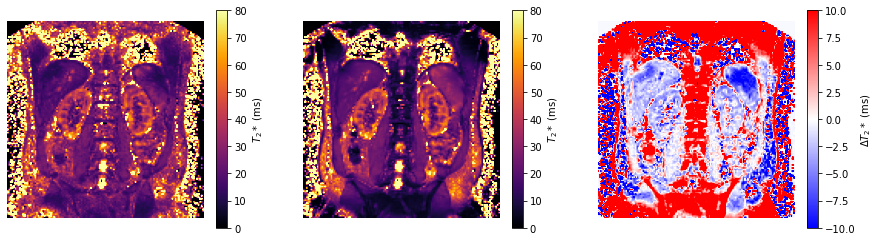

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Display a central slice of the log linear T2* map
im = ax1.imshow(np.rot90(t2star_loglin[:, :, 2]), cmap='inferno', clim=(0, 80))
cb = fig.colorbar(im, ax=ax1)
cb.set_label('$T_2*$ (ms)')
ax1.axis('off')

# Display a central slice of the exponential curve fit T2* map
im = ax2.imshow(np.rot90(t2star_2p_exp[:, :, 2]), cmap='inferno', clim=(0, 80))
cb = fig.colorbar(im, ax=ax2)
cb.set_label('$T_2*$ (ms)')
ax2.axis('off')

# Display the difference between the two mapping methods
im = ax3.imshow(np.rot90(t2star_loglin[:, :, 2] - t2star_2p_exp[:, :, 2]), cmap='bwr', clim=(-10, 10))
cb = fig.colorbar(im, ax=ax3)
cb.set_label('$\Delta T_2*$ (ms)')
ax3.axis('off')

plt.show()